
# Comprehensive Exploratory Data Analysis (EDA) - Home Task

## Objective:
In this task, you'll be working with a Black Friday sales dataset. The dataset contains anonymized demographic data of customers, along with the products they purchased and the purchase amount.

**Try to create Generic Functions and store them at the top of the notebook, after libraries import**
 The analysis should cover the following:
1. Data Cleaning
2. Outlier Detection
3. Exploratory Data Analysis (EDA)
4. Statistical Analysis
5. Conclusions

**Dataset Overview:**
- **User_ID**: Unique customer ID
- **Product_ID**: Unique product ID
- **Gender**: Gender of the customer
- **Age**: Age group of the customer
- **Occupation**: Customer's occupation code
- **City_Category**: Category of the city (A, B, or C)
- **Stay_In_Current_City_Years**: Number of years the customer has stayed in the current city
- **Marital_Status**: 0 indicates single, 1 indicates married
- **Product_Category_1, Product_Category_2, Product_Category_3**: Product category codes for the purchased product
- **Purchase**: Purchase amount

---



## 0. Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ff

## 0a. Read csv

In [51]:
df = pd.read_csv('BlackFriday.csv')

In [3]:
df.sample(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
393530,1000570,P00237642,M,26-35,4,A,4+,0,5,14.0,NaN,6925
235609,1000331,P0099442,M,26-35,7,B,1,0,6,8.0,NaN,12706
229036,1005321,P00221442,M,26-35,4,C,0,0,1,2.0,5.0,7850


## 0b. Data Observation

In [52]:
def data_observation(df):
    # Display basic information about the dataset
    print("Dataset Info:")
    df.info()
        
    print("\nSample of the data:")
    print(df.sample(5))
    
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    print("\nDuplicate Rows:")
    print(f"Number of duplicate rows: {df.duplicated().sum()}")
    
    print("\nUnique Values in Categorical Columns:")
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    print("\nValue Counts and Normalized Percentages for Categorical Columns:")
    for col in categorical_columns:
        value_counts = df[col].value_counts()
        normalized_counts = df[col].value_counts(normalize=True) * 100
        print(f"\n{col}:")
        for value, count in value_counts.items():
            normalized = normalized_counts[value]
            print(f"- {value}: {count} ({normalized:.2f}%)")
    
    # Check for spaces and uppercase letters in column names
    columns_to_clean = [col for col in df.columns if ' ' in col or not col.islower()]
    if columns_to_clean:
        print("\nColumn names to be cleaned:")
        for col in columns_to_clean:
            print(f"- {col}")

data_observation(df)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     537577 non-null  int64  
 1   Product_ID                  537577 non-null  object 
 2   Gender                      537577 non-null  object 
 3   Age                         537577 non-null  object 
 4   Occupation                  537577 non-null  int64  
 5   City_Category               537577 non-null  object 
 6   Stay_In_Current_City_Years  537577 non-null  object 
 7   Marital_Status              537577 non-null  int64  
 8   Product_Category_1          537577 non-null  int64  
 9   Product_Category_2          370591 non-null  float64
 10  Product_Category_3          164278 non-null  float64
 11  Purchase                    537577 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


 ### Description: We have good data without duplicates, nulls or illogical values. But we have to clean column names.
 - 537577 rows
 - Product_ID: 3623 unique values
 - Gender: 2 unique values
 - Age: 7 unique values
 - City_Category: 3 unique values
 - Stay_In_Current_City_Years: 5 unique values
 - Product_categories - 18 unique values.
 - Occupation - 20 unique values
 - Max Purchase = 23961, mean = 9333, min = 185 (we have no zero purchases)
 - We have more M than F: 75% vs 25%.
 - Most common age is: "26-35" = 40% clients
 - Most popular city category is "B" = 42%
 - Most popular "Stay in current city" parameter is "1" (35.19%)

## 0c. Memory Optimization

In [48]:
def data_optimization(df):
    # Create a copy of the dataframe to avoid modifying the original
    df_o = df.copy()
    
    # Optimize numeric columns
    def optimize_numeric_column(col, df_o):
        col_min = df_o[col].min()
        col_max = df_o[col].max()
        has_nulls = df_o[col].isna().sum() > 0
        prefix = 'U' if has_nulls else ''

        def get_int_dtype(min_val, max_val):
            if min_val >= 0:
                if max_val < 255: return f'{prefix}Int8'
                elif max_val < 65535: return f'{prefix}Int16'
                elif max_val < 4294967295: return f'{prefix}Int32'
                else: return f'{prefix}Int64'
            else:
                if min_val > -128 and max_val < 127: return f'{prefix}Int8'
                elif min_val > -32768 and max_val < 32767: return f'{prefix}Int16'
                elif min_val > -2147483648 and max_val < 2147483647: return f'{prefix}Int32'
                else: return f'{prefix}Int64'

        if df_o[col].dtype == 'float64':
            if df_o[col].notnull().eq(df_o[col].notnull().astype(int)).all():
                return df_o[col].astype(get_int_dtype(col_min, col_max))
            # If float column has decimal values, leave it as is
            return df_o[col]
        else:  # Integer columns
            return df_o[col].astype(get_int_dtype(col_min, col_max))

    for col in df_o.select_dtypes(include=['int64', 'float64']).columns:
        df_o[col] = optimize_numeric_column(col, df_o)
    
    # Optimize categorical columns
    for col in df_o.select_dtypes(include=['object']).columns:
        if df_o[col].nunique() / len(df_o) < 0.5:  # If less than 50% unique values
            df_o[col] = df_o[col].astype('category')
    
    # Optimize date columns (assuming 'Stay_In_Current_City_Years' might be a date)
    date_columns = ['Stay_In_Current_City_Years']  # Add more date columns if present
    for col in date_columns:
        if col in df_o.columns:
            try:
                df_o[col] = pd.to_datetime(df_o[col])
            except:
                pass  # If conversion fails, leave as is
    
    # Print memory usage improvement
    print(f"Original memory usage: {df.memory_usage().sum() / 1e6:.2f} MB")
    print(f"Optimized memory usage: {df_o.memory_usage().sum() / 1e6:.2f} MB")
    print(f"Memory usage reduced by {(1 - df_o.memory_usage().sum() / df.memory_usage().sum()) * 100:.2f}%")
    
    return df_o


In [46]:
df = data_optimization(df)
df.info()

Original memory usage: 51.61 MB
Optimized memory usage: 13.06 MB
Memory usage reduced by 74.69%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     537577 non-null  Int32   
 1   Product_ID                  537577 non-null  category
 2   Gender                      537577 non-null  category
 3   Age                         537577 non-null  category
 4   Occupation                  537577 non-null  Int8    
 5   City_Category               537577 non-null  category
 6   Stay_In_Current_City_Years  537577 non-null  category
 7   Marital_Status              537577 non-null  Int8    
 8   Product_Category_1          537577 non-null  Int8    
 9   Product_Category_2          370591 non-null  UInt8   
 10  Product_Category_3          164278 non-null  UInt8   
 11  Purchase             

C:\Users\пользователь\AppData\Local\Temp\ipykernel_13220\572266934.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_o[col] = pd.to_datetime(df_o[col])



## 1. Data Cleaning


In [58]:
ff.lowercase(df)

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
...,...,...,...,...,...,...,...,...,...,...,...,...
537572,1004737,P00193542,M,36-45,16,C,1,0,1,2.0,NaN,11664
537573,1004737,P00111142,M,36-45,16,C,1,0,1,15.0,16.0,19196
537574,1004737,P00345942,M,36-45,16,C,1,0,8,15.0,NaN,8043
537575,1004737,P00285842,M,36-45,16,C,1,0,5,NaN,NaN,7172



## 2. Outlier Detection

- **Outliers in Purchase Amount**: Identify and visualize any outliers in the Purchase column.
- **Handling Outliers**: Decide whether to keep or remove the outliers, and justify your choice.


In [55]:
def define_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

def define_outliers_zscore(df, col, threshold=3):
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    return df[z_scores > threshold]

def define_outliers_percentile(df, col, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[col].quantile(lower_percentile)
    upper_bound = df[col].quantile(upper_percentile)
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

def define_outliers(df, col):
    outliers_iqr = define_outliers_iqr(df, col)
    outliers_zscore = define_outliers_zscore(df, col)
    outliers_percentile = define_outliers_percentile(df, col)
    
    return {
        'IQR': outliers_iqr,
        'Z-Score': outliers_zscore,
        'Percentile': outliers_percentile
    }

<Axes: ylabel='purchase'>

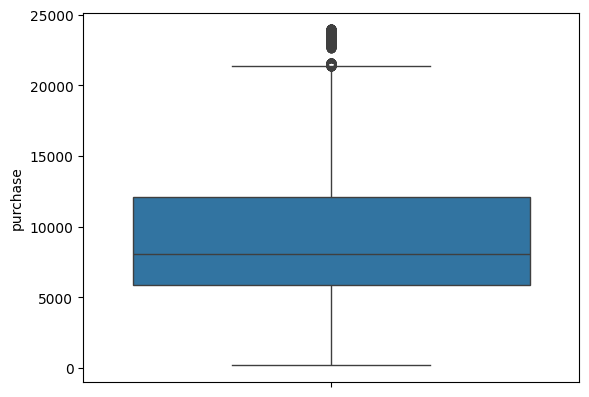

In [60]:
sns.boxplot(df['purchase'])


## 3. Exploratory Data Analysis (EDA)

**You Decide what to do! check atleast 5 different things**

In [ ]:
# Distribution of Purchase amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Purchase'], kde=True)
plt.title('Distribution of Purchase Amounts')
plt.show()

# Average purchase amount by Gender
plt.figure(figsize=(8, 5))
sns.barplot(x='Gender', y='Purchase', data=df)
plt.title('Average Purchase Amount by Gender')
plt.show()

# Correlation heatmap for numerical variables
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


## 4. Statistical Analysis

- **Correlation Analysis**: Figure out on what to test correlation and explain it
- **Purchase Distribution**: Apply statistical tests to determine if the distribution of Purchase amounts significantly differs between different demographic groups (e.g., Gender or Marital Status).



## 5. Conclusions

- Highlight any surprising trends or findings that could be useful for understanding customer behavior.
- Provide recommendations based on the analysis (e.g., targeted marketing strategies based on demographics).
